In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [2]:
hbinint = 10
vbinint = 0.3
label_dict = {
    0: "normal",
    1: "rotor < 5",
    2: "power neg",
    3: "h outlier",
    5: "v low stack",
    6: "v dbscan",
}

In [58]:
# laod data
df = pd.read_csv("dataset.csv")
df["label"] = 0

In [46]:
def plot(df, num = 1, no_v_move = True):
    # arg "no_v_move": 
    #     whether the data has been passed to "v_move" function

    # take windnumber 1 fof example by default
    subdf = df[df.WindNumber == num]
    if no_v_move: subdf["OldWindSpeed"] = subdf.WindSpeed

    fig, ax = plt.subplots(2, 2, figsize = (8, 8))
    # title
    _ = ax[0][0].set_title(num); _ = ax[1][0].set_title(num)
    _ = ax[0][1].set_title(num); _ = ax[1][1].set_title(num)

    # scatter of original windspeed ~ power (with outlier labels)
    scatter = ax[0][0].scatter(subdf.OldWindSpeed, subdf.Power, s = 0.1, c = subdf.label, cmap = "tab10")
    _ = ax[0][0].legend(handles=scatter.legend_elements()[0], labels=label_dict.values())

    # scatter of original windspeed ~ power (nomal data only)
    _ = ax[0][1].scatter(subdf.OldWindSpeed[subdf.label == 0], subdf.Power[subdf.label == 0], s = 0.1)

    # scatter of v_moved windspeed ~ power (with outlier labels)
    scatter = ax[1][0].scatter(subdf.WindSpeed, subdf.Power, s = 0.1, c = subdf.label, cmap = "tab10")
    _ = ax[1][0].legend(handles=scatter.legend_elements()[0], labels=label_dict.values())

    # scatter of v_moved windspeed ~ power (nomal data only)
    _ = ax[1][1].scatter(subdf.WindSpeed[subdf.label == 0], subdf.Power[subdf.label == 0], s = 0.1) 
    fig.show()
    # plt.close(fig)

# a sub-df for demo
demo_df = df[df.WindNumber == 1]

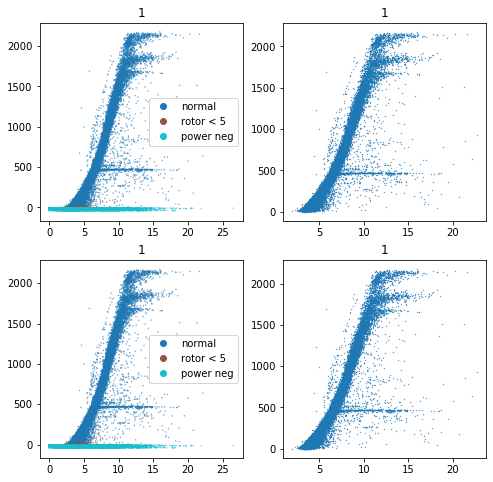

In [47]:
# remove negative power (label 2) and low rotorspeed (label 1)
def remove_neg(df):
    keep = df[df.label != 0]
    df = df[df.label == 0]
    df.loc[df.RotorSpeed < 4, "label"] = 1
    df.loc[df.Power < 0, "label"] = 2
    return pd.concat([df, keep], sort = False).reset_index(drop = True)
demo_df = remove_neg(demo_df)
plot(demo_df)

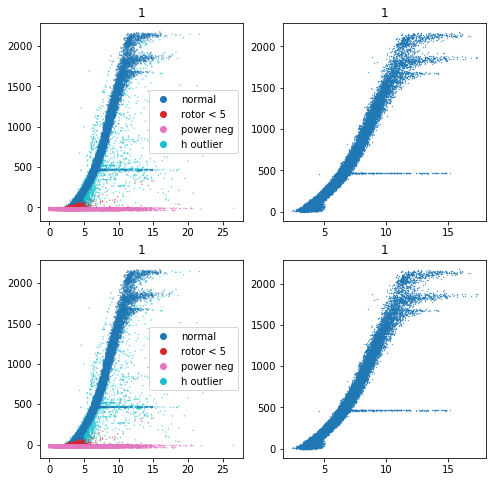

In [6]:
def remove_h_out(df):
    keep = df[df.label != 0]
    df = df[df.label == 0]
    bins = pd.cut(df.Power, np.arange(-1000, 3000, hbinint))
    df["hbins"] = bins
    groups = []
    for name, group in df.groupby("hbins"):
        if group.shape[0] == 0:
            continue
        q1 = np.quantile(group.WindSpeed, 0.25)
        q3 = np.quantile(group.WindSpeed, 0.75)
        iqr = q3 - q1
        fl = q1 - 1.5 * iqr
        fu = q3 + 1.5 * iqr
        group.loc[np.bitwise_or(group.WindSpeed < fl, group.WindSpeed > fu),"label"] = 3
        groups.append(group)
    df = pd.concat(groups, sort = False).reset_index(drop = True)
    return pd.concat([df, keep], sort = False).reset_index(drop = True)

demo_df = remove_h_out(demo_df)
plot(demo_df)

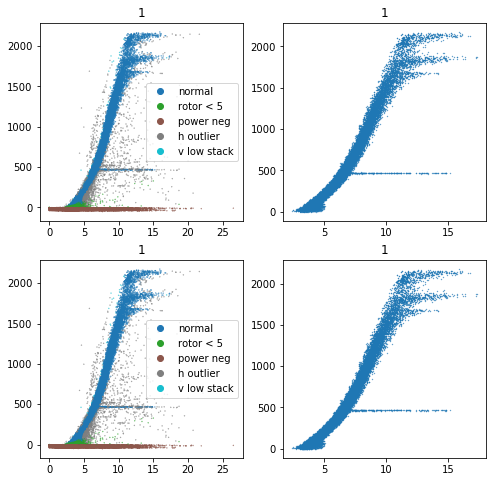

In [7]:
# slice windspeed by binwidth (vbinint)
# remove 3IQR outlier of each bin (label 4)
def remove_v_out(df):
    keep = df[df.label != 0]
    df = df[df.label == 0]
    bins = pd.cut(df.WindSpeed, np.arange(-15, 30, vbinint))
    df["vbins"] = bins
    groups = []
    for name, group in df.groupby("vbins"):
        if group.shape[0] == 0:
            continue
        q1 = np.quantile(group.Power, 0.25)
        q3 = np.quantile(group.Power, 0.75)
        fl = 2.5 * q1 - 1.5 * q3
        fu = 2.5 * q3 - 1.5 * q1
        group.loc[group.Power > fu,"label"] = 4
        groups.append(group)
    df = pd.concat(groups, sort = False).reset_index(drop = True)
    return pd.concat([df, keep], sort = False).reset_index(drop = True)

demo_df = remove_v_out(demo_df)
plot(demo_df)

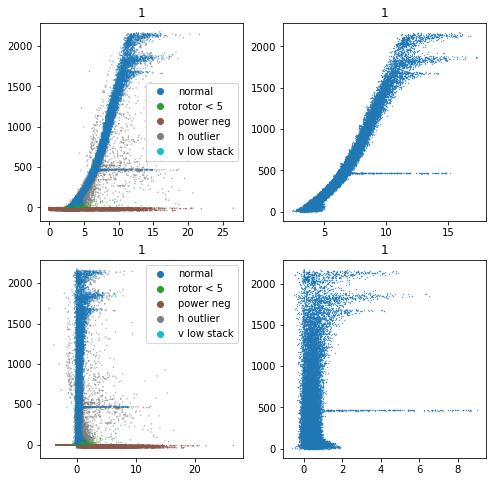

In [8]:
# move data to be vertivcal aligned
# save the original WindSpeed to OldWindSpeed column
# the new WindSpeed columns is aligned
def v_move(df):
    num = np.unique(df.WindNumber)[0]
    df["OldWindSpeed"] = df.WindSpeed
    bins = pd.cut(df.Power, np.arange(-1000, 3000, hbinint))
    df["hbins"] = bins
    groups = []
    for name, group in df.groupby("hbins"):
        if np.sum(group.label == 0) == 0:
            groups.append(group)
            continue
        group.WindSpeed -= np.quantile(group.WindSpeed[group.label == 0], 0.05)
        groups.append(group)
    df = pd.concat(groups, sort = False).reset_index(drop = True)
    return df.reset_index(drop = True)

demo_df = v_move(demo_df)
plot(demo_df, no_v_move = False)

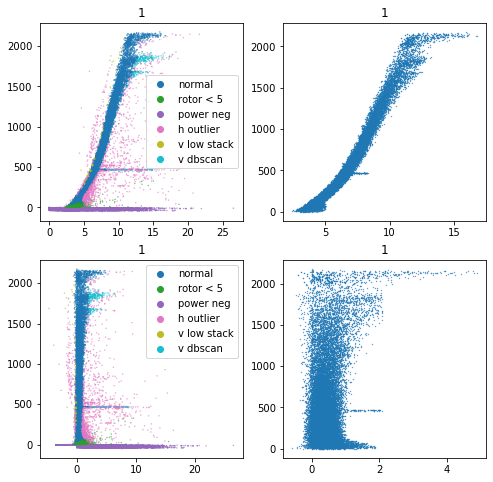

In [9]:
# remove some lower stack points except the highest stack (where the power reaches the rated power ~ 2000)
# this kind of outlier is labeled with 5
# the lower stack is defined as lower than 0.9 *max(power) ~= 1900
def remove_v_out_low(df):
    num = np.unique(df.WindNumber)[0]
    keep = df[df.label != 0]
    df = df[df.label == 0]
    bins = pd.cut(df.WindSpeed, np.arange(-15, 30, vbinint))
    df["vbins"] = bins
    groups = []
    for name, group in df.groupby("vbins"):
        if group.shape[0] == 0:
            continue
        if name.left > 2:
            group.loc[group.Power < np.max(df.Power) * 0.9, "label"] = 5
        groups.append(group)
    df = pd.concat(groups, sort = False).reset_index(drop = True)
    return pd.concat([df, keep], sort = False).reset_index(drop = True)

demo_df = remove_v_out_low(demo_df)
plot(demo_df, no_v_move = False)



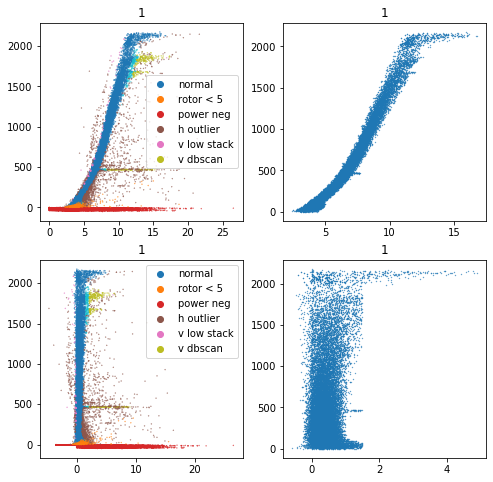

In [10]:
# to improve the accuracy of removing low stack points
# I use DBSCAN clustering the find the low stack clusters and remove them
# this kind of outliers are labeled with 6
# SORRY for the confusing codes to distinguish normal points cluster from abnormal clusters ...
def remove_v_dbscan(df):
    num = np.unique(df.WindNumber)[0]
    keep = df[df.label != 0]
    df = df[df.label == 0]
    bins = pd.cut(df.WindSpeed, np.arange(-15, 30, vbinint))
    df["vbins"] = bins
    groups = []
    dbscan = DBSCAN(40, min_samples = 5)
    for name, group in df.groupby("vbins"):
        if group.shape[0] < 5 or name.left < 1.5:
            groups.append(group)
            continue
        label = dbscan.fit_predict(group[["Power"]])
        group["cls"] = label
        clsmean = group.groupby("cls").apply(lambda x: np.mean(x.Power))
        if len(clsmean) != 1:
            clsmean = clsmean[clsmean.index != -1]
        maxcls = clsmean.sort_values().index[-1]
        group["label"] = [0 if l == maxcls else 6 for l in label]
        group = group.drop(columns = ["cls"])
        groups.append(group)
    df = pd.concat(groups, sort = False).reset_index(drop = True)
    return pd.concat([df, keep], sort = False).reset_index(drop = True)

demo_df = remove_v_dbscan(demo_df)
plot(demo_df, no_v_move = False)

In [11]:
# some functions to reassign the label
def withdraw_v_out(df):
    df.loc[df.label == 4, "label"] = 0
    return df

def withdraw_h_out(df):
    df.loc[df.label == 3, "label"] = 0
    return df

In [ ]:
# a combine of several remove functions
# you can custom define the order of these functions
def remove(df):
    df = remove_neg(df)
    df = remove_h_out(df)
    df = remove_v_out(df)
    df = v_move(df)
    df = remove_v_out_low(df)
    df = remove_v_dbscan(df)
    df = withdraw_v_out(df)
    df = withdraw_h_out(df)
    df = remove_h_out(df)
    return df

demo_df = df[df.WindNumber == 1]
demo_df = remove(demo_df)
plot(demo_df, no_v_move = False)

In [13]:
# do this for all windnumber
sub = []
for windnumber in np.unique(df.WindNumber):
    subdf = remove(df[df.WindNumber == windnumber])
    sub.append(subdf)

sub = pd.concat(sub)

In [14]:
sub = sub[["WindNumber", "Time","label"]]
print(Counter(sub.label))
sub.label = (sub.label != 0).astype(np.int)
sub

Counter({0: 305486, 2: 104016, 1: 46797, 3: 22480, 5: 13069, 6: 5989})


,WindNumber,Time,label
0,1,2017/12/17 5:50,0
1,1,2018/1/27 19:40,0
2,1,2018/6/13 18:50,0
3,1,2018/1/5 4:00,0
4,1,2018/5/23 7:00,0
...,...,...,...
46716,12,2019/5/20 7:00,1
46717,12,2019/10/30 10:30,1
46718,12,2019/3/10 17:00,1
46719,12,2019/5/20 5:50,1


In [ ]:
#实验

In [49]:
demo_df = df[df.WindNumber == 9]
demo_df = remove(demo_df)
demo_df = demo_df.sort_values(by='Time')
demo_df.label = (demo_df.label != 0).astype(np.int)
demo_df

,WindNumber,Time,WindSpeed,Power,RotorSpeed,label,hbins,vbins,OldWindSpeed
3293,9,2017/11/1 0:10,1.132359,71.090909,5.769091,0,"(70, 80]","(0.9, 1.2]",4.742727
6181,9,2017/11/1 0:20,0.567471,137.100000,8.685500,0,"(130, 140]","(0.3, 0.6]",4.765000
5638,9,2017/11/1 0:30,0.360829,129.684211,8.667895,0,"(120, 130]","(0.3, 0.6]",4.431579
5982,9,2017/11/1 0:40,0.298787,132.157895,8.676316,0,"(130, 140]","(3.55e-14, 0.3]",4.496316
7313,9,2017/11/1 0:50,0.502700,153.888889,8.770000,0,"(150, 160]","(0.3, 0.6]",4.836667
...,...,...,...,...,...,...,...,...,...
39455,9,2018/9/9 8:50,2.990000,-14.000000,0.130000,1,"(-20, -10]",NaN,2.990000
39456,9,2018/9/9 9:00,2.550000,-10.500000,0.130000,1,"(-20, -10]",NaN,2.550000
39457,9,2018/9/9 9:10,1.620000,-10.500000,0.130000,1,"(-20, -10]",NaN,1.620000
39458,9,2018/9/9 9:20,1.350000,-10.500000,0.130000,1,"(-20, -10]",NaN,1.350000


In [53]:
df = pd.read_csv("dataset.csv")
df = df[df['WindNumber']==9]
df = df.sort_values(by='Time')
demo_df = demo_df.sort_values(by='Time')
df['label']=list(demo_df['label'])


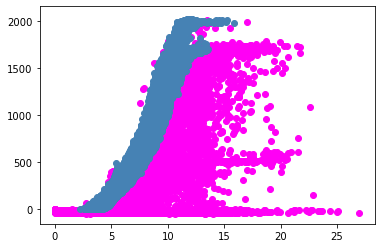

In [56]:
d0 = df[df['label']==0]
d1 = df[df['label']==1]

plt.scatter(d1['WindSpeed'],d1['Power'],c='#FF00F5')
plt.scatter(d0['WindSpeed'],d0['Power'],c='#4682B4')
plt.show()